# QTS Final Project

In [188]:
import os 
import pandas as pd 
import numpy as np
import quandl 
import wrds
import functools
import matplotlib.pyplot as plt

from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA

import warnings 
warnings.filterwarnings('ignore')

In [2]:
KEY = os.getenv('QUANDL_KEY')
quandl.ApiConfig.api_key = KEY # Insert your key here if you want to run the code yourself 

In [658]:
conn = wrds.Connection(wrds_username="seanl59")

Loading library list...
Done


## Data Retrieval

In [4]:
START_DATE = '2014-01-01'
END_DATE = '2021-12-31'

In [5]:
@functools.lru_cache()
def fetch_quandl(asset, begin_date=None, end_date=None):
    '''
    Retrieves Quandl data 

    Parameters:
    asset (string): Asset to be retrieved
    begin_date (string): Start date of data retrieval
    end_date (string): End date of data retrieval 

    Returns:
    qdata (DataFrame): DataFrame of asset data 
    '''
    qdata = quandl.get(asset,
                      start_date = begin_date,
                      end_date = end_date,
                      paginate=True)
    return qdata

In [6]:
@functools.lru_cache()
def fetch_quandl_table(table, ticker, begin_date = None, end_date = None):
    '''
    Retrieves Quandl table data 

    Parameters:
    table (string): The table to retrieve 
    ticker (string): The ticker from the table 
    begin_date (string): Start date of data retrieval
    end_date (string): End date of data retrieval 

    Returns:
    qdata (DataFrame): DataFrame of asset data 
    '''
    qdata = quandl.get_table(table,
                      date = { 'gte': begin_date, 'lte': end_date },
                      qopts = {"columns":["date", "adj_close", "close","adj_volume"]},
                      ticker = ticker,
                      paginate=True)
    qdata = qdata.set_index('date').sort_index(ascending=True)
    return qdata

I've added get_contract() in order to obtain rolled future-contract data. With the expiration dates, the front month becomes less-liquid and there are discontinuities in price. This function is from my Homework 2 (where we had to roll contracts).

In [7]:
def get_contract(name,years,month_codes,start=START_DATE,end=END_DATE,multiplier=1): 
    '''
    Obtains future contract price information given the month and year codes 

    Parameters:
        name (string): Name of the contract assuming OWF database 
        years (list): List of years of contract expiry
        month_codes (list): List of month codes of contract expiry 
        start (string): The start date of price data (default 2020-21-03)
        end (string): The end date of price data (default 2022-08-31)
        multiplier (float): Multiplier that is applied to the future price (default 1)

    Returns:
        df_filtered (df): Dataframe consisting of future price time-series with desired multiplier applied 
    '''
    df = pd.DataFrame()
    for y in years:
        for m in month_codes:
            code = 'OWF/' + name + '_' + m + y + '_IVM'
            qdata = quandl.get(code, returns='pandas', api_key=KEY, start_date=start, end_date=end)
            df = pd.concat([df, qdata.reset_index()])
    df_filtered = df.sort_values(by=['Date','DtT'])
    df_filtered = df_filtered[df_filtered.DtT >= 30].groupby('Date').first()
    df_filtered = multiplier * df_filtered[['Future']].rename(columns={'Future':'Price'})
    return df_filtered

For simplicity, there is no optimization and (1,1,1) will be used (just like the research paper). The paper was released in 2006 so there is no look-ahead bias with this.

**TODO:** Ask Brian: Is it okay to not optimize and just use the result straight from the paper? 

In [8]:
filename = './data/vix_data.csv'
vix_data = pd.read_csv(filename)
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])
vix_data = vix_data.set_index('DATE')[['CLOSE']]
vix_data = vix_data.loc[START_DATE:END_DATE]

In [9]:
filename = './data/economic_calendar.csv'
event_data = pd.read_csv(filename)
event_data['DATE'] = pd.to_datetime(event_data['Start']).dt.date
event_data = event_data.set_index('DATE')

idx = vix_data.index
all_dates = pd.date_range(START_DATE,END_DATE)

temp = vix_data.copy()
temp.columns = ['VIX']
temp = temp.reindex(idx, fill_value=None)
temp['Event'] = np.where(temp.index.isin(event_data.index.values), True, False)
temp['Days until Event'] = np.where(temp['Event'] == True, 0, vix_data.groupby((temp['Event'] == True).cumsum()).cumcount(ascending=False)+1)
temp = temp.dropna(subset=['VIX'])
temp = temp[['VIX', 'Days until Event']]

When using Quandl, we now need close prices to determine ATM option prices. 

**TODO:** Also ask Brian, what should we do for these ATM option calculations in regards to adj-close and close prices.

In [10]:
spy_data = fetch_quandl_table('QUOTEMEDIA/PRICES','SPY',begin_date=START_DATE,end_date=END_DATE)
spy_data.columns = ['Adj. Close', 'Close', 'SPY Volume']
trading_days = spy_data.index 
temp = temp.loc[temp.index.isin(trading_days)]

In [11]:
filename = './data/ssec_data.csv'
ssec_data = pd.read_csv(filename)
ssec_data['Date'] = pd.to_datetime(ssec_data['Date'])
ssec_data = ssec_data.set_index('Date')
ssec_data = ssec_data.loc[ssec_data.index.isin(trading_days)].sort_index(ascending=True)
ssec_data = ssec_data[['Price']].rename(columns={'Price':'SSEC'})
ssec_data = ssec_data['SSEC'].str.replace(',','').astype(float).to_frame()

In [12]:
years = ['2014','2015','2016','2017','2018','2019','2020','2021','2022']
month_codes = ['H','M','U','Z']

cl_data = get_contract('NYM_CL_CL', years, month_codes)
cl_data = cl_data.loc[START_DATE:END_DATE].rename(columns={'Price':'CL'})

In [13]:
all_data = pd.concat([temp, spy_data, ssec_data, cl_data], axis=1)

all_data['VIX Returns'] = all_data['VIX'].pct_change()
all_data['SPY Returns'] = all_data['Adj. Close'].pct_change() # We will still use adjusted close percent change
all_data['SSEC Returns'] = all_data['SSEC'].pct_change()
all_data['CL Returns'] = all_data['CL'].pct_change()

predictors = all_data[['Days until Event','SPY Volume','VIX Returns','SPY Returns','SSEC Returns','CL Returns']].dropna()

In [14]:
predictors['VIX Returns (y)'] = predictors['VIX Returns'].shift(-1)
predictors['SSEC Returns'] = predictors['SSEC Returns'].shift(-1)
predictors['Days until Event'] = predictors['Days until Event'].shift(-1)
predictors = predictors.drop(columns=['VIX Returns'])
predictors = predictors.dropna()

In [15]:
start, end = 0, 126
predicted_results = pd.DataFrame(index=predictors.iloc[126:].index,columns=['predictions'])
for i in tqdm(range(len(predictors.iloc[126:]))):
    model = ARIMA(predictors.iloc[start:end]['VIX Returns (y)'], order=(1,1,1), exog=predictors.iloc[start:end,:5]).fit()
    forecast = model.forecast(1, exog=predictors.iloc[end,:5])

    start, end = start + 1, end + 1  
    predicted_results.iloc[i] = forecast

predicted_results = predicted_results.dropna()
predicted_results['actual'] = predictors.iloc[126:,5]

100%|██████████| 1887/1887 [02:38<00:00, 11.93it/s]


For now, we'll also keep the thresholds as 0.07 and -0.07. We will likely have to change this later and give rationale. We can potentially do some historical threshold.

In [53]:
predicted_results['predictions'] = predicted_results['predictions'].astype(float)

In [63]:
POS_THRESH = 0.07 
NEG_THRESH = -0.07

metrics = pd.DataFrame(index=['Metrics'],columns=['MSE','DA','Up Acc','Down Acc'])

mse = np.mean((predicted_results['actual'] - predicted_results['predictions'])**2)
da = (np.sign(predicted_results['predictions']) == np.sign(predicted_results['actual'])).sum() / len(predicted_results)

sig_up = predicted_results[predicted_results['predictions'] >= POS_THRESH]
sig_down = predicted_results[predicted_results['predictions'] <= NEG_THRESH]

acc_up = (np.sign(sig_up['predictions']) == np.sign(sig_up['actual'])).sum() / len(sig_up)
acc_down = (np.sign(sig_down['predictions']) == np.sign(sig_down['actual'])).sum() / len(sig_down)

metrics.loc['Metrics'] = [mse,da,acc_up,acc_down]
metrics

,MSE,DA,Up Acc,Down Acc
Metrics,0.013106,0.502385,0.431694,0.580153


## Tradeable Assets

Assets we will use (for now):
- SPY 
- SPY Vanilla Options
- 20+ Year Bond ETF
- GC (Gold Futures)

Other options:
- CL (Crude Oil Futures)
- VIX Futures (rolling v. continuous?)

In rest of notebook, we use SPY, SPY Options, 20+ Yr Bond ETF, GC, CL

In [660]:
def retrieve_options(date: str, conn=conn) -> pd.DataFrame:
    query = f"""
    SELECT symbol, date, exdate, cp_flag, best_bid, strike_price,
        best_offer, impl_volatility, delta, gamma, vega, theta 
    FROM optionm_all.opprcd{date[:4]}
    WHERE 1=1
        AND date = '{date}'
        AND symbol like 'SPY%%'
        AND ABS(delta) < 1.0
        AND cp_flag = 'C'
    """
    df = conn.raw_sql(query)
    return df

In [87]:
preds = predicted_results.copy()
preds['VIX Signal'] = 0 
preds.loc[preds['predictions'] >= POS_THRESH, 'VIX Signal'] = 1 
preds.loc[preds['predictions'] <= NEG_THRESH, 'VIX Signal'] = -1

def generate_positions(dataframe,days_to_hold=2):
    current_position = 'none'
    time_to_last_trade = 0
    for day in preds.index.values:
        signal = dataframe.loc[day]['VIX Signal']
        if current_position == 'none':
            if signal == 1:
                current_position = 'long'
                time_to_last_trade = days_to_hold 
            elif signal == -1:
                current_position = 'short'
                time_to_last_trade = days_to_hold 
        elif current_position == 'long':
            if signal == -1:
                current_position = 'short'
                time_to_last_trade += 1 
            elif signal == 1:
                time_to_last_trade = 1 
            elif time_to_last_trade >= days_to_hold:
                current_position = 'none'
            else:
                time_to_last_trade += 1 
        elif current_position == 'short':
            if signal == -1:
                time_to_last_trade = 1 
            elif signal == 1:
                current_position = 'long'
                time_to_last_trade = 1 
            elif time_to_last_trade >= days_to_hold:
                current_position = 'none'
            else:
                time_to_last_trade += 1 
        dataframe.loc[day, 'position'] = current_position 

    signals_df = pd.DataFrame(index=dataframe.index, columns=['signal'])
    signals_df.loc[dataframe['position'] == 'long', 'signal'] = 1
    signals_df.loc[dataframe['position'] == 'short', 'signal'] = -1 
    signals_df.loc[dataframe['position'] == 'none', 'signal'] = 0
    return signals_df 

signals_df = generate_positions(preds, 2)

In [148]:
gc_data = get_contract('CMX_GC_GC', years, month_codes)
gc_data = gc_data[gc_data.index.isin(signals_df.index)]

In [195]:
tlt_data = fetch_quandl_table('QUOTEMEDIA/PRICES','TLT')
tlt_data = tlt_data[tlt_data.index.isin(signals_df.index)]
tlt_data.columns = ['Price','Close','Volume']

In [161]:
cl_data_asset = cl_data.copy()
cl_data_asset = cl_data_asset[cl_data_asset.index.isin(signals_df.index)]
cl_data_asset.columns = ['Price']

In [167]:
def backtester(signals_df, asset, direction=1):
    dates = signals_df.index
    cur_signal = 0 
    cur_pos = 0
    prev_price = 0

    returns_df = pd.DataFrame(index=dates)
    for i in dates:
        date_signal = signals_df.loc[i, 'signal']
        cur_price = asset.loc[i, 'Price']

        daily_pnl = cur_pos * (cur_price - prev_price)

        if date_signal != cur_signal: 
            if date_signal != 0: # Open a new position 
                cur_pos = 1 * date_signal * direction # 1 contract for now 
                cur_signal = date_signal 
                prev_price = cur_price  
            else: # Close the position 
                cur_pos, cur_signal = 0, 0
    
        returns_df.loc[i, 'Daily PnL'] = daily_pnl 

    return returns_df 


Text(0.5, 1.0, 'GC Futures')

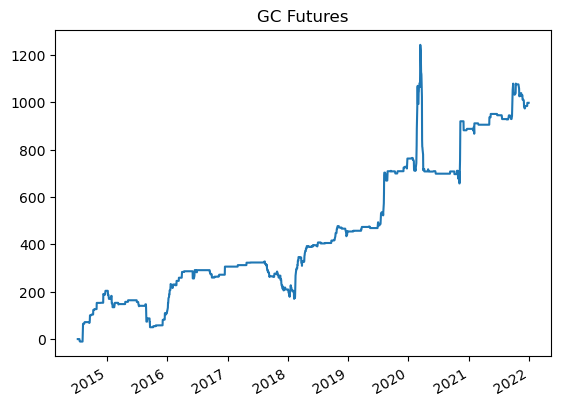

In [229]:
gc_rets = backtester(signals_df,gc_data,direction=1)
gc_rets['Total PnL'] = gc_rets['Daily PnL'].cumsum()
gc_rets['Total PnL'].plot()
plt.title('GC Futures')

Text(0.5, 1.0, 'CL Futures')

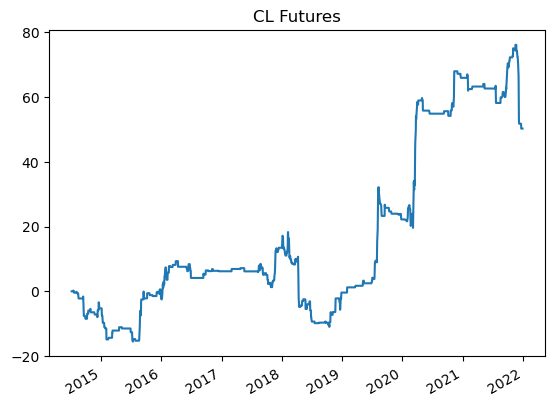

In [191]:
cl_rets = backtester(signals_df,cl_data_asset,direction=-1)
cl_rets['Total PnL'] = cl_rets['Daily PnL'].cumsum()
cl_rets['Total PnL'].plot()
plt.title('CL Futures')

Text(0.5, 1.0, '20+ YR Bond')

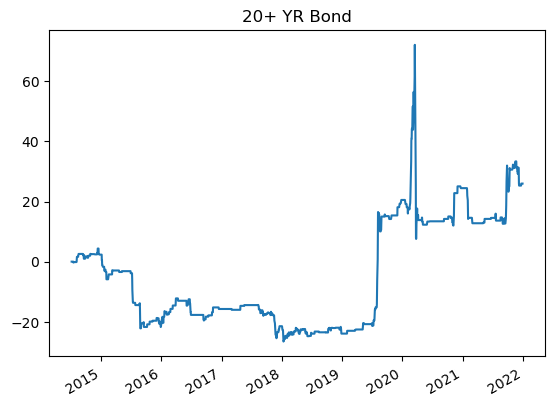

In [198]:
tlt_rets = backtester(signals_df,tlt_data)
tlt_rets['Total PnL'] = tlt_rets['Daily PnL'].cumsum()
tlt_rets['Total PnL'].plot()
plt.title('20+ YR Bond')

<AxesSubplot: >

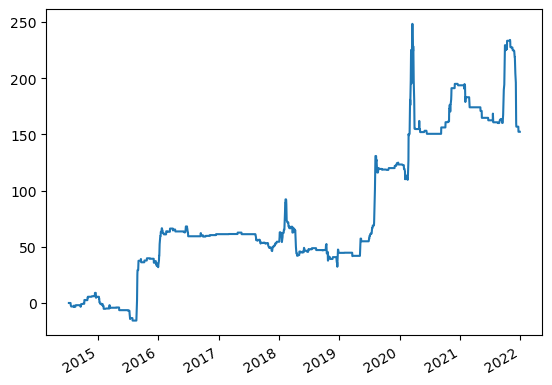

In [217]:
spy_data_asset = spy_data.loc[spy_data.index.isin(signals_df.index),:]
spy_data_asset = spy_data_asset['Adj. Close'].to_frame('Price')
spy_rets = backtester(signals_df,spy_data_asset,direction=-1)
spy_rets['Total PnL'] = spy_rets['Daily PnL'].cumsum()
spy_rets['Total PnL'].plot()

Text(0.5, 1.0, 'SPY ETF')

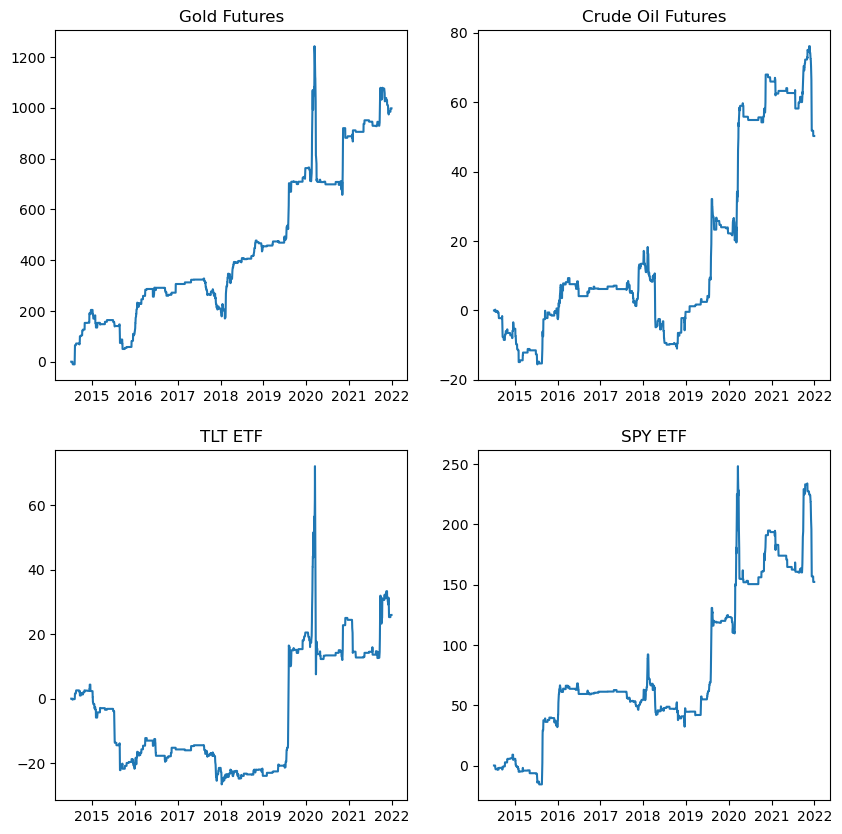

In [237]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].plot(gc_rets['Total PnL'],label='Gold Futures')
ax[0,1].plot(cl_rets['Total PnL'],label='Crude Oil Futures')
ax[1,0].plot(tlt_rets['Total PnL'],label='TLT ETF')
ax[1,1].plot(spy_rets['Total PnL'],label='SPY ETF')

ax[0,0].set_title('Gold Futures')
ax[0,1].set_title('Crude Oil Futures')
ax[1,0].set_title('TLT ETF')
ax[1,1].set_title('SPY ETF')

In [661]:
in_pos = True 
options_chain = pd.DataFrame()

for date in tqdm(signals_df.index):
    signal = signals_df.loc[date].item()
    date_str = date.strftime('%Y-%m-%d')
    if (in_pos == True) and (signal == 0):
        options = retrieve_options(date_str)
        options_chain = pd.concat([options_chain, options])
        in_pos = False 
    elif signal != 0:
        options = retrieve_options(date_str)
        options_chain = pd.concat([options_chain, options])
        in_pos = True   

100%|██████████| 1887/1887 [15:07<00:00,  2.08it/s]


In [662]:
options_chain.to_csv('options_chain.csv')

In [663]:
filename = './data/options_chain.csv'
options_chain = pd.read_csv(filename,index_col=0)
options_chain['date'] = pd.to_datetime(options_chain['date'])

In [757]:
def backtest_options(signals_df,options_chain,how_far=4,spy_data=spy_data):
    dates = signals_df.index 
    cur_signal = 0
    returns_df = pd.DataFrame(index=dates)
    id, atm_strike = None, None 
    cur_price, prev_price = 0, 0
    cur_pos = 0 
    daily_pnl = 0
    reverse = False
    
    for date in dates:
        date_signal = signals_df.loc[date, 'signal']
        date_str = date.strftime('%Y-%m-%d')
        total_delta = 0
        if date_signal != cur_signal: # Either close or reverse 
            if date_signal != 0:
                if cur_signal == -1 * date_signal: # to reverse
                    reverse = True 
                    old_id = id 
                    prev_strike = atm_strike 
                    id = None 
                atm_strike = int(np.floor(spy_data.loc[date,'Close']))

            options = options_chain[(options_chain['date'] == date_str) & (options_chain['strike_price'] == atm_strike*1000)].sort_values(by='exdate')

            if id:
                cur_option = options[options['symbol'] == id]
            else:
                cur_option = options.iloc[[how_far]]
                delta = cur_option['delta']
                id = cur_option['symbol'].item()

            cur_price = (1/2) * (cur_option['best_offer'].item() + cur_option['best_bid'].item())

            if reverse == True:
                prev_option = options_chain[(options_chain['date'] == date_str) & (options_chain['strike_price'] == prev_strike*1000) & (options_chain['symbol'] == old_id)].sort_values(by='exdate')
                last_atm_cur_price = (1/2) * (prev_option['best_offer'].item() + prev_option['best_bid'].item())
                daily_pnl = cur_pos * (last_atm_cur_price - prev_price)
                reverse = False 
                old_id = None 
            else:
                daily_pnl = cur_pos * (cur_price - prev_price)

            prev_price = cur_price 

            if date_signal == 1: # 1 option for now 
                cur_pos, cur_signal = 100, 1
            elif date_signal == -1:
                cur_pos, cur_signal = -100, -1
            else:
                cur_pos, cur_signal = 0, 0
                id = None 
            
            total_delta = np.abs(delta * cur_pos)

        else: # Now do nothing
            if date_signal != 0:
                options = options_chain[(options_chain['date'] == date_str) & (options_chain['strike_price'] == atm_strike*1000)].sort_values(by='exdate')
                cur_option = options[(options['symbol'] == id)]
                cur_price = (cur_option['best_offer'].item() + cur_option['best_bid'].item())/2 
                daily_pnl = cur_pos * (cur_price - prev_price)
                prev_price = cur_price 
            else:
                daily_pnl = 0

        returns_df.loc[date,['Daily PnL','Delta']] = [daily_pnl, total_delta] 
    
    return returns_df  

In [758]:
options_rets = backtest_options(signals_df,options_chain,5)

In [772]:
options_rets['Total PnL'] = options_rets['Daily PnL'].cumsum()

Now let's build the delta hedge

We need delta $ amount of SPY (i.e delta / cost fractional shares) (will do this based off adjusted close)

copy pasting for now

In [759]:
deltas = options_rets[['Delta']]

In [763]:
dates = signals_df.index
cur_signal = 0 
cur_pos = 0 
prev_price = 0 
DIR = -1 

delta_hedge_rets = pd.DataFrame(index=dates)
for i in dates:
    date_signal = signals_df.loc[i, 'signal']
    cur_price = spy_data_asset.loc[i, 'Price']

    daily_pnl = cur_pos * (cur_price - prev_price)

    if date_signal != cur_signal: 
        if date_signal != 0: # Open a new position 
            cur_pos = np.abs(deltas.loc[i].item()) * date_signal * DIR 
            cur_signal = date_signal 
            prev_price = cur_price  
        else: # Close the position 
            cur_pos, cur_signal = 0, 0

    delta_hedge_rets.loc[i, 'Daily PnL'] = daily_pnl 


<AxesSubplot: >

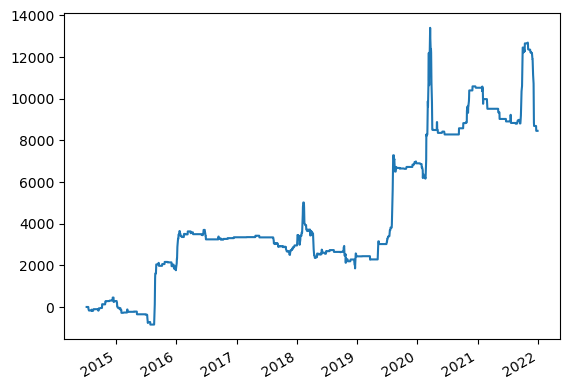

In [764]:
delta_hedge_rets['Total PnL'] = delta_hedge_rets['Daily PnL'].cumsum()
delta_hedge_rets['Total PnL'].plot()

In [776]:
delta_hedge = delta_hedge_rets[['Total PnL']].rename(columns={'Total PnL':'SPY'})
delta_hedge = pd.concat([delta_hedge,options_rets[['Total PnL']].rename(columns={'Total PnL':'SPY Calls'})],axis=1)
delta_hedge['Total PnL'] = delta_hedge['SPY'] + delta_hedge['SPY Calls']

<AxesSubplot: >

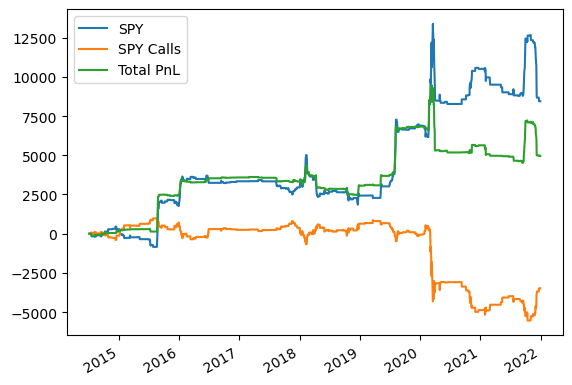

In [778]:
delta_hedge.plot()